In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.block_gru import Block_GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub10_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub10_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 100
E_no = 2000
I_no = 200
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 4
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
#V_test = V[-50000:].to(device).float()
V_test = V[50000*993:50000*994].to(device).float()

#test_E_neural = E_neural[-50000:].toarray()
#test_I_neural = I_neural[-50000:].toarray()
test_E_neural = E_neural[50000*993:50000*994].toarray()
test_I_neural = I_neural[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Block_GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)

# GRU (1 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025/(1**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

35902


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred = model(batch_E_neural, batch_I_neural)
    s = time.time()
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 50)
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-e0b30868a6e3>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.006432 0.034695
49 0.231422 0.026566
99 0.28318 0.024846
149 0.306522 0.023896
199 0.322131 0.023358
249 0.316154 0.023562
299 0.331014 0.02308
349 0.346797 0.022636
399 0.326446 0.023233
449 0.349617 0.022424
499 0.365322 0.021888
549 0.399916 0.020674
599 0.384239 0.021282
649 0.350008 0.022409
699 0.410016 0.020345
749 0.428875 0.019684
799 0.410334 0.020339
849 0.461906 0.018537
899 0.442968 0.019198
949 0.481141 0.017901
999 0.42818 0.019869
1049 0.453283 0.018843
1099 0.485612 0.01786
1149 0.507955 0.017079
1199 0.491749 0.017883
1249 0.520734 0.016625
1299 0.437876 0.019383
1349 0.471623 0.01825
1399 0.5117 0.016914
1449 0.49762 0.017338
1499 0.555942 0.0153
1549 0.503713 0.017102
1599 0.486641 0.017687
1649 0.473866 0.018126
1699 0.573827 0.014682
1749 0.54313 0.01578
1799 0.561679 0.015186
1849 0.566257 0.014974
1899 0.566978 0.01493
1949 0.528103 0.016265
1999 0.548821 0.015572
2049 0.577086 0.01459
2099 0.544624 0.015693
2149 0.599251 0.013823
2199 0.530829 0.016193
224

17749 0.683146 0.010916
17799 0.631778 0.012686
17849 0.711015 0.009957
17899 0.692279 0.010602
17949 0.650072 0.012128
17999 0.70888 0.010088
18049 0.700263 0.010336
18099 0.668888 0.011414
18149 0.573536 0.014694
18199 0.655988 0.011921
18249 0.662465 0.011652
18299 0.701571 0.010282
18349 0.706378 0.010159
18399 0.716058 0.009784
18449 0.705079 0.010165
18499 0.68105 0.010989
18549 0.65676 0.011833
18599 0.659056 0.011747
18649 0.691604 0.010637
18699 0.703832 0.010204
18749 0.714596 0.009832
18799 0.689642 0.010692
18849 0.697263 0.010443
18899 0.694674 0.010523
18949 0.553018 0.015414
18999 0.627447 0.012835
19049 0.595598 0.013954
19099 0.591037 0.014092
19149 0.704632 0.010199
19199 0.715707 0.009798
19249 0.7073 0.01009
19299 0.755547 0.008431
19349 0.6727 0.011295
19399 0.674842 0.011221
19449 0.637823 0.012487
19499 0.682536 0.010987
19549 0.700388 0.010333
19599 0.592933 0.014031


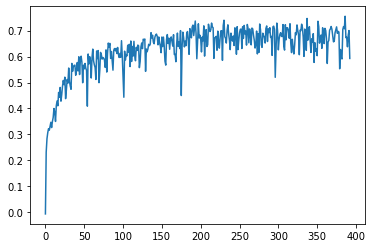

In [7]:
plt.plot(np.asarray(score_list))

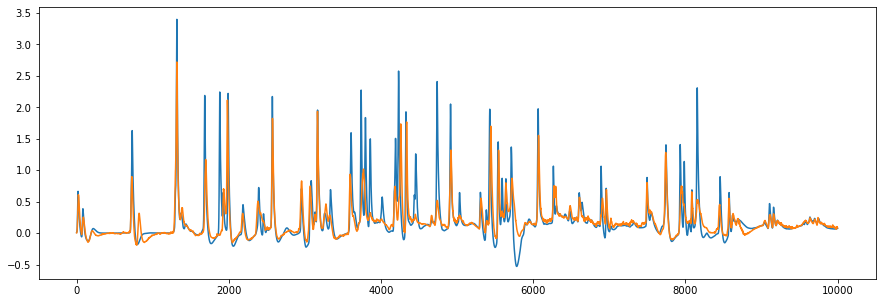

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/block/gru_s10_h100.pt")